## Backgound
Analysis of the Chemotaxis model described by Spiro et al., PNAS, 1999.
The model describes the receptor state along 3 dimensions:
  - bound to a ligand
  - phosphorylated
  - degree of methylation (considers 2, 3, 4)
  
Key variables are:
   - Y, Yp - concentrations of CheY and its phosphorylated form
   - B, Bp - concentrations of CheB and its phosphorylated form
   - L - ligand concentration
   - f<state>, t<state> - "f" indicates the fraction of the concentration in the state, "t" is the total
     <state> is a 3 character string, such as "TT2". T/F indicates the boolean value; the last is an integer.

## Summary

Initially, we consider a step response. Later, we repeat the same analysis for a ramp. These correspond to the analyses done by Spiro.

Most of the analysis is done using fractional concentrations (variables that begin with "f"). We begin by justifying this.

Next, we analyze the effects of a step response. "Perfect adaptation" is possible if the step is small enough.

## Software Dependencies
The model and various utility functions are in the python modules chemotaxis_model and data_plotter.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tellurium as te
from chemotaxis_model import ChemotaxisModel, StateAggregationFactory
from data_plotter import DataPlotter
model = ChemotaxisModel()

/home/ubuntu/miniconda2/lib/python2.7/site-packages/tellurium/notebooks/__init__.py:16: UserWarning: Notebook tools are not imported, due to missing dependencies.
  warnings.warn("Notebook tools are not imported, due to missing dependencies.")


## Antimony Model

In [2]:
print model.getModel()


        J0: $x0 -> L; k0*x0
        # REACTIONS from Table 3
        # Methylation
        J1: T2R -> T3 + R; k1c*T2R
        J2: T3R -> T4 + R; k2c*T3R
        J3: LT2R -> LT3 + R; k3c*LT2R
        J4: LT3R -> LT4 + R; k4c*LT3R
        #   Details of Tn + R <-> TnR
        J5: T2R -> T2 + R; k1a*T2R
        J6: T2 + R -> T2R; k1b*T2*R
        J7: T3R -> T3 + R; k2a*T3R
        J8: T3 + R -> T3R; k2b*T3*R
        #J9: T4R -> T4 + R; k3a*T4R
        #J10: T4 + R -> T4R; k3b*T4*R
        #   Details of LTn + R <-> LTnR (not in Spiro)
        J11: LT2R -> LT2 + R; k1a*LT2R
        J12: LT2 + R -> LT2R; k1b*LT2*R
        J13: LT3R -> LT3 + R; k2a*LT3R
        J14: LT3 + R -> LT3R; k2b*LT3*R
        #J15: LT4R -> LT4 + R; k3a*LT4R
        #J16: LT4 + R -> LT4R; k3b*LT4*R
        # Demethylation reactions
        J17: T3 + Bp -> T2 + Bp; k_1*T3*Bp
        J18: T4 + Bp -> T3 + Bp; k_2*T4*Bp  
        J19: LT3 + Bp -> LT2 + Bp; k_3*LT3*Bp
        J20: LT4 + Bp -> LT3 + Bp; k_4*LT4*Bp
        

## Common Codes Used in this Analysis

In [18]:
# Runs simulation and creates global variables used in analysis
def sim(elements=None):
    """
    Runs the simulation and creates global names
    Input: global variable model - the ChemotaxisModel
        elements - elements to add to the model
    Output: global variables - plotter, result
    """
    if elements is None:
      elements = []
    global plotter, result
    model = ChemotaxisModel()
    for element in elements:
      model.appendToModel(element)
    model.initialize()
    result = model.run(end=300)
    plotter = DataPlotter(model)


## Justification for Fractional Concentrations

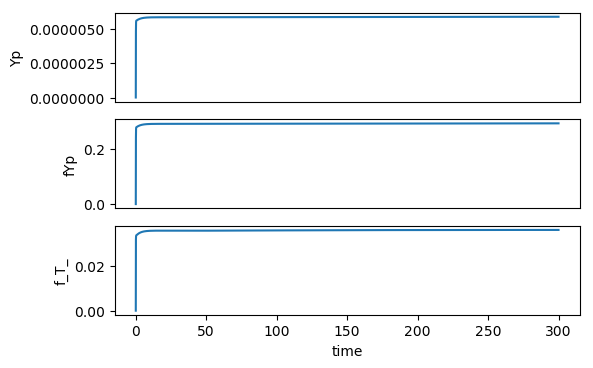

In [20]:
# Analysis for L = 0
sim()
plotter.lines(["Yp", "fYp", "f_T_"])

Observations
- Although the scales differ, the shape of Yp and fYp are identical.
- The Yp response corresponds to the shape of the fraction of methylated receptor

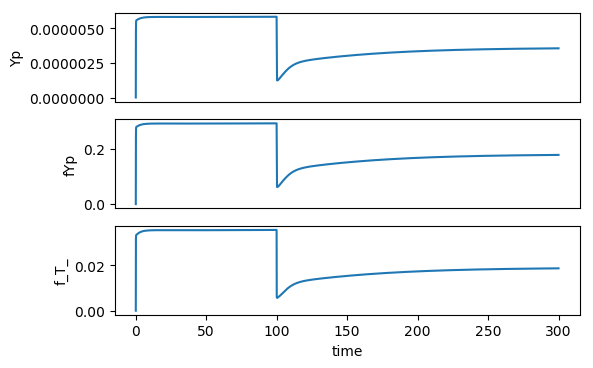

In [21]:
# Step Analysis for a change at 100
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["Yp", "fYp", "f_T_"])

Observations

- Once again, it suffices to look at the fraction of methylated receptors.

In [ ]:
# Step Analysis
model.appendToModel('''at (time > 100): L = 11e-6''')
sim()
plotter.lines(["Yp", "fYp", "fTT3"])

In [ ]:
# Step Analysis


model = ChemotaxisModel()
model.appendToModel('''at (time > 100): L = 11e-6''')
sim()

P = states.sumStates(lambda l,p,m: p)
plt.subplot(3,1,1)
plt.xlabel("time")
plt.ylabel("Yp")
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
plt.plot( time, result['[Yp]'])
plt.subplot(3,1,2)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
plt.xlabel("time")
plt.ylabel("L")
plt.plot(time, result['[L]'])
plt.subplot(3,1,3)
plt.xlabel("time")
plt.axis([0, 200, 0, 1.01])
#plt.plot(time, frYp, 'b', time, frLTp, 'g')
plt.ylabel("fLp")
plt.plot(time, f.v("fTT_"))

In [ ]:
m = 4
n = 1
plt.subplot(m,1,n); n += 1
plt.plot(time, result['[Yp]'], 'g', time, result['[L]'], 'r')
plt.subplot(m,1,n); n+= 1
plt.plot(time,frLTp, 'r', time, frp, 'g', time, frTp, 'b')
plt.subplot(m,1,n); n += 1
plt.plot(time, frLT3p, 'g', time, frLT4p, 'b')
plt.subplot(m, 1, n)
plt.plot(time, frLT2, 'r')

Loosing some of the receptors as indicated in the above plot.

Ramp analysis

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tellurium as te
from chemotaxis_model import ChemotaxisModel

model = ChemotaxisModel()
#model.appendToModel('''at (time > 200): L = 0.11e-6''')
model.appendToModel('''at (time > 101): k0 = 0.011e-6''')
model.appendToModel('''at (time > 200): k0 = 0, L=0.11e-6''')
sim()

P = states.sumStates(lambda l,p,m: p)
plt.plot( time, result['[Yp]'], 'b', time, P, 'r', time, result['[L]'], 'g')
#rr.plot(result, xlim=[0, end_time])

Questions:
1. Why doesn't Yp return to its pre-ramp state?
2. 
Observations:
1. P drops to 0 at time

In [ ]:
frp = states.frcStates(lambda l,p,m: p)
frLTp = states.frcStates(lambda l,p,m: l and p)
plt.subplot(4,1,1)
plt.plot( time, frp, 'b', time, frTp, 'r', time, frLTp, 'g')
plt.subplot(4,1,3)
frL = states.frcStates(lambda l,p,m: l)
plt.plot( time, frL, 'r', time, frLT4, 'g', time, frLT4p, 'b')

In [ ]:
frLTp

Expected to see an impulse response in response to the step input. But see a step response in Yp.

In [ ]:
Ids = ['J11', 'J12', 'J3']
{id: model.getReactionRateForId(id) for id in Ids}